In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import EMNIST
from torchvision import transforms

In [2]:
class CNN_EMnist(nn.Module):
    def __init__(self, input_channel):
        super(CNN_EMnist, self).__init__()

        self.dw1 = nn.Sequential(
            nn.Conv2d(input_channel, 32, kernel_size=5),
            nn.ReLU(),
        )

        self.dw2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5),
            nn.ReLU(),            
        )

        self.up1 = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=5) 
        )

        self.up2 = nn.Sequential(            
            nn.ReLU(),
            nn.ConvTranspose2d(32, input_channel, kernel_size=5) 
        )

        self.act = nn.Sigmoid()


    def forward(self, x):
        x = self.dw1(x)
        x= self.dw2(x)
        x = self.up1(x)
        x = self.up2(x)
        x = self.act(x)
        return x

In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ]
)

trainset = EMNIST(root='~/data', split = "byclass", train=True, download=True, transform=transform)
train_dl = DataLoader(trainset, batch_size=1024, shuffle=True, num_workers=2)
testset = EMNIST(root='~/data', split = "byclass", train=False, download=True, transform=transform)
test_dl = DataLoader(testset, batch_size=1024, shuffle=False, num_workers=2)

print(len(train_dl), len(test_dl))

682 114


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = CNN_EMnist(input_channel=1).to(device)

optimizer = Adam(model.parameters(), lr = 0.0001)

loss_fn = nn.MSELoss()

In [5]:
for epoch in range(10):
    model.train()
    tr_total_loss = 0
    for train_img, _ in tqdm(train_dl):
        train_img = train_img.to(device)

        gen_img = model(train_img)
        train_loss = loss_fn(gen_img, train_img)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        tr_total_loss += train_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = 0
        for valid_img, _ in tqdm(test_dl):
            valid_img = valid_img.to(device)

            gen_img = model(valid_img)

            valid_loss = loss_fn(gen_img, valid_img)

            va_total_loss += valid_loss.item()

    print(f"Epoch: {epoch} - TrainLoss: {tr_total_loss/len(train_dl)} - ValidLoss: {va_total_loss/len(test_dl)}")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:21<00:00,  5.34it/s]


Epoch: 0 - TrainLoss: 0.5367893636488844 - ValidLoss: 0.5033204286244878


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:21<00:00,  5.42it/s]


Epoch: 1 - TrainLoss: 0.5016146698567874 - ValidLoss: 0.5006070432432911


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:21<00:00,  5.32it/s]


Epoch: 2 - TrainLoss: 0.5002042337858782 - ValidLoss: 0.4998656181912673


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:21<00:00,  5.39it/s]


Epoch: 3 - TrainLoss: 0.4996934825898615 - ValidLoss: 0.4994997186096091


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:21<00:00,  5.35it/s]


Epoch: 4 - TrainLoss: 0.49941483699331535 - ValidLoss: 0.4993062586637965


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:20<00:00,  5.45it/s]


Epoch: 5 - TrainLoss: 0.49923517325581696 - ValidLoss: 0.4991430804917687


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:21<00:00,  5.32it/s]


Epoch: 6 - TrainLoss: 0.4991098555389388 - ValidLoss: 0.4990912064125663


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:21<00:00,  5.32it/s]


Epoch: 7 - TrainLoss: 0.4990246247423709 - ValidLoss: 0.4989581087179351


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:21<00:00,  5.38it/s]


Epoch: 8 - TrainLoss: 0.49895267345863353 - ValidLoss: 0.4989653888501619


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:21<00:00,  5.30it/s]

Epoch: 9 - TrainLoss: 0.4988999770970638 - ValidLoss: 0.4988805298742495


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.07it/s]


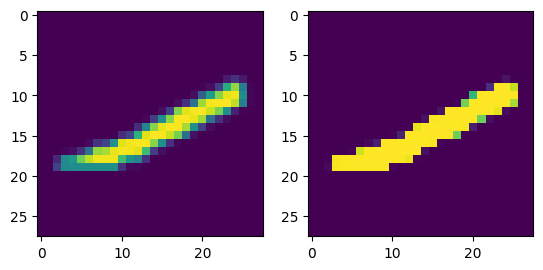

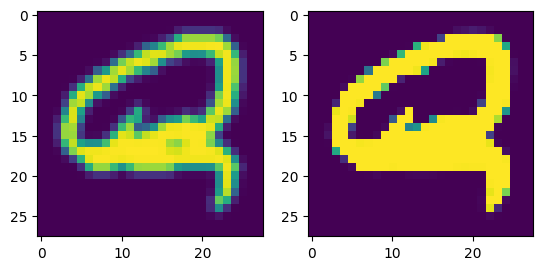

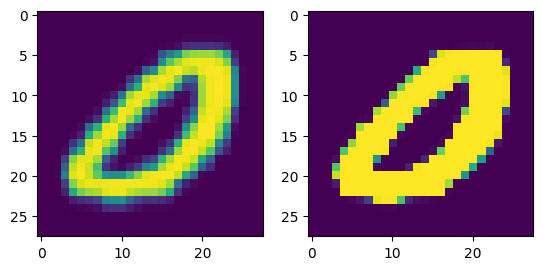

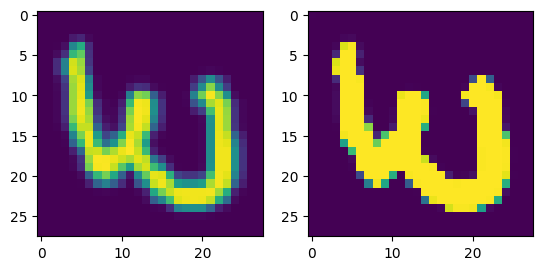

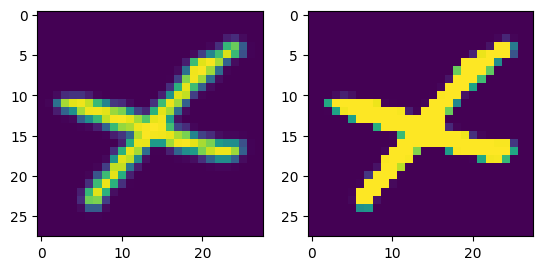

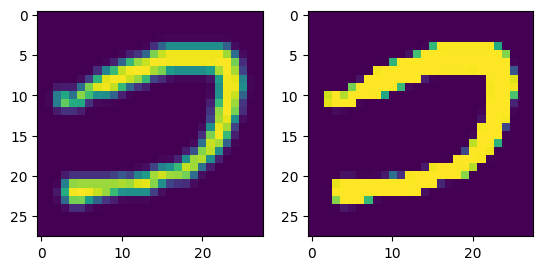

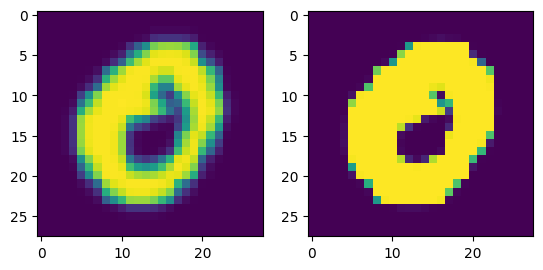

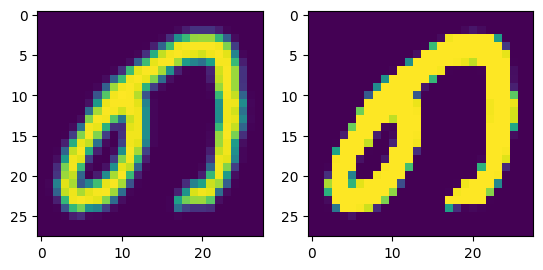

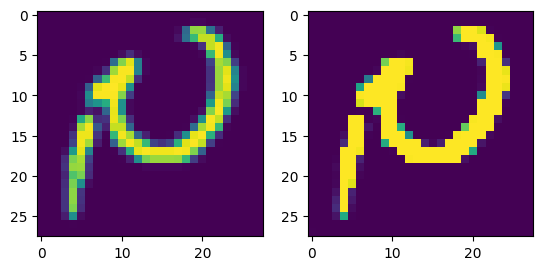

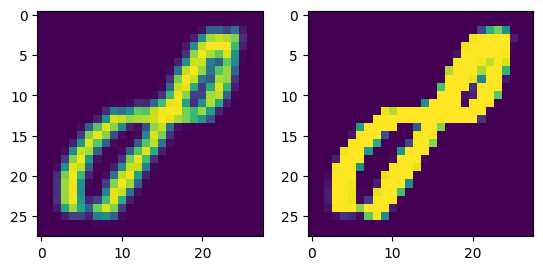

In [6]:
model.eval()
with torch.no_grad():
    for test_case_idx in tqdm(range(10)):
        valid_img, _ = testset[test_case_idx]
        valid_img = valid_img.unsqueeze(dim=0).to(device)

        gen_img = model(valid_img)        

        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(valid_img[0].cpu().permute(1, -1, 0).numpy())
        axarr[1].imshow(gen_img[0].cpu().permute(1, -1, 0).numpy())